# NeuralForecast Model Integration

This notebook demonstrates how to use [NeuralForecast](https://nixtlaverse.nixtla.io/neuralforecast/docs/) models in Darts through the `NeuralForecastModel` wrapper.

`NeuralForecastModel` converts any of the 30+ NeuralForecast base models into a Darts `TorchForecastingModel`, giving access to the full Darts torch ecosystem: covariates, probabilistic forecasting, optimized historical forecasts/backtesting, model saving/loading, and more.

**Supported models include**: TiDE, PatchTST, KAN, NBEATSx, TSMixer, TimeXer, iTransformer, FEDformer, Autoformer, Informer, and many others.

**Installation**: `NeuralForecastModel` requires the `neuralforecast` package (not included in `darts[all]`). For example you can install the package from PyPI with:

```bash
pip install "neuralforecast>=3.0.0"
```

Other installation options can be found in the [NeuralForeacst installation guide](https://nixtlaverse.nixtla.io/neuralforecast/docs/getting-started/installation.html).

For more details, see the [Darts documentation](https://unit8co.github.io/darts/) and the original [NeuralForecast documentation](https://nixtlaverse.nixtla.io/neuralforecast/docs/).

The follwing topics are covered in this notebook:
* [Quick Start: Univariate Forecasting](#1.-Quick-Start:-Univariate-Forecasting)
* [Forecasting Using Covariates](#2.-Forecasting-Using-Covariates)
* [Historical Forecasts & Backtesting](#3.-Historical-Forecasts-&-Backtesting)
* [Multivariate Forecasting](#4.-Multivariate-Forecasting)
* [Multiple Series Forecasting](#5.-Multiple-Series-Forecasting)
* [Probabilistic Forecasting](#6.-Probabilistic-Forecasting)
* [Comparison: Darts TiDE vs NeuralForecast TiDE](#7.-Comparison:-Darts-TiDE-vs-NeuralForecast-TiDE)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import warnings

import numpy as np
import pandas as pd

from darts import set_option
from darts.datasets import AirPassengersDataset
from darts.metrics import mae, mape, rmse
from darts.models import NeuralForecastModel, TiDEModel
from darts.utils.likelihood_models import QuantileRegression

warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

set_option("plotting.use_darts_style", True)

## 1. Quick Start: Univariate Forecasting

Let's start with a simple univariate (single column) forecast example using the AirPassengers dataset.

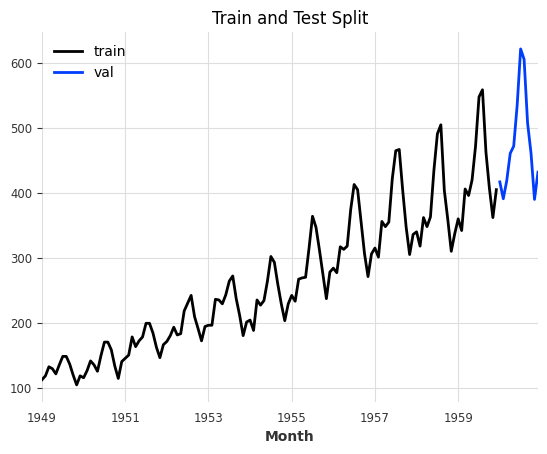

In [3]:
series = AirPassengersDataset().load().astype("float32")

# the models input and output windows
input_chunk_length = 24
output_chunk_length = 12

# extract a training and validation set for illustration
train, val = series[:-output_chunk_length], series[-output_chunk_length:]

train.plot(label="train")
val.plot(label="val", title="Train and Test Split");

Using `NeuralForecastModel` is straightforward: set `model` to any NeuralForecast base model name (as a string) or class (see all available models [here](https://nixtlaverse.nixtla.io/neuralforecast/docs/capabilities/overview.html)), and pass model-specific architectural parameters via `model_kwargs`. Everything else (training, covariates, likelihoods) works exactly like any other Darts `TorchForecastingModel`.

<div class="alert alert-success" role="alert">
    **Info**: Darts will take care of automatically setting non-architectural parameters for you. These parameters **will be ignored** in `model_kwargs`:
    <ol>
        <li>**Input and output parameters**: `input_size`, `h`, and `n_series` These are automatically set to match the `input_chunk_length`, `output_chunk_length`, and number of target series (components), respectively.
        <li>**Covariate parameters**: `futr_exog_list`, `hist_exog_list`, and `stat_exog_list`. These are inferred directly from the input time series passed to `fit()`.
        <li>**Training and PyTorch (Lightning)-related setup**: `loss`, `learning_rate`, `max_steps`, etc. are all handled by Darts. You can specify these parameters directly. You can find all parameters in the `kwargs` parameter description [here](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tide_model.html#darts.models.forecasting.tide_model.TiDEModel).
    </ol>
</div>

Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

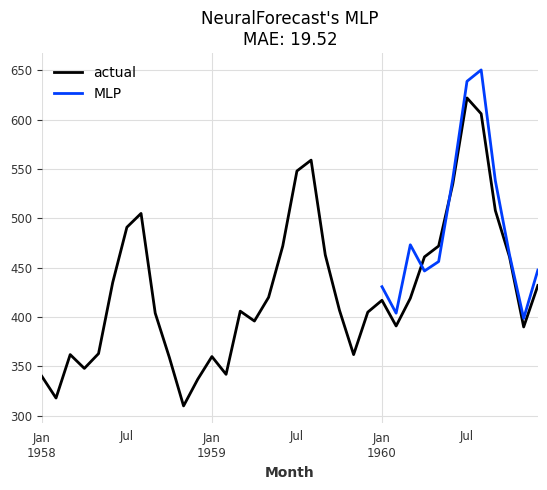

In [4]:
# define parameters shared by all Darts' models
darts_kwargs = dict(
    input_chunk_length=input_chunk_length,  # the model's input window
    output_chunk_length=output_chunk_length,  # the model's output window
    use_reversible_instance_norm=True,  # reversible instance normalization against distribution shift
    n_epochs=50,  # train the model for 50 epochs
    random_state=42,
    pl_trainer_kwargs=dict(
        accelerator="auto"
    ),  # configure the PyTorch Lightning Trainer for advanced techniques
)

model = NeuralForecastModel(
    model="MLP",
    model_kwargs=dict(
        num_layers=2, hidden_size=1024
    ),  # set NeuralForecast model hyperparameters
    **darts_kwargs,
)

# train and predict; training only on a single series allows us to call `predict()` without having to pass a `series`.
# the forecast will start after the end of that training series
model.fit(train)
pred = model.predict(n=output_chunk_length)

# plot
series[-3 * output_chunk_length :].plot(label="actual")
pred.plot(label="MLP", title=f"NeuralForecast's MLP\nMAE: {mae(val, pred):.2f}");

## 2. Forecasting Using Covariates

Many NeuralForecast models support covariates. The wrapper automatically detects which covariate types are supported by the chosen base model and wires them into the Darts pipeline. There is no need to specify `futr_exog_list`, `hist_exog_list`, and `stat_exog_list`. These are inferred directly from the input time series passed to `NeuralForecastModel.fit()`.

Since we don't have any future covariates at hand, let's generate some from calendar attributes of the AirPassengers series and see whether including them has an impact on model performance.

<div class="alert alert-success" role="alert">
  **Tip**: For simplicity, you can also let the model generate these features for you with the `add_encoders` parameter. More info in the [quickstart](https://unit8co.github.io/darts/quickstart/00-quickstart.html#Encoders:-using-covariates-for-free). 
</div>

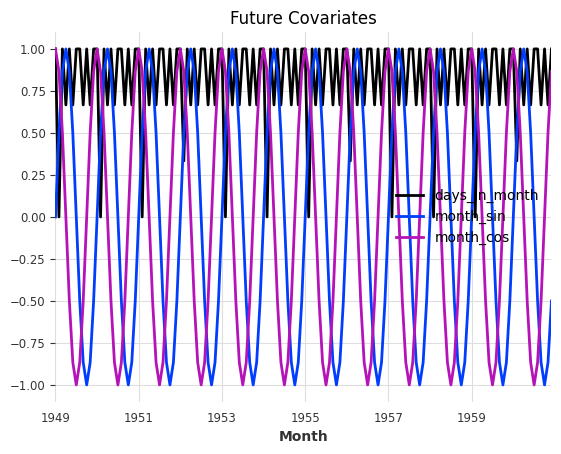

In [5]:
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# generate feature: number of days per month, and apply a MinMax scaler to scale all values into the range (0,1)
future_covariates = datetime_attribute_timeseries(series, attribute="days_in_month")
future_covariates = Scaler().fit_transform(future_covariates)

# let's also add a cyclic encoding (sin + cosine wave) of the value the month
future_covariates = future_covariates.add_datetime_attribute(
    "month", cyclic=True
).astype("float32")

# finally, display everything
future_covariates.plot(title="Future Covariates");

Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

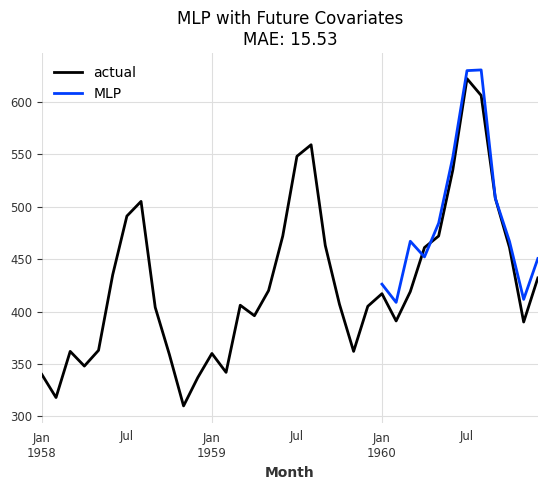

In [6]:
# the MLP model supports all types or covariates, let's get a fresh model instance
model = model.untrained_model()

# fit and predict
model.fit(train, future_covariates=future_covariates)
forecast_cov = model.predict(n=output_chunk_length)

# plot
series[-3 * output_chunk_length :].plot(label="actual")
forecast_cov.plot(
    label="MLP", title=f"MLP with Future Covariates\nMAE: {mae(val, forecast_cov):.2f}"
);

Great, it looks like the model performs better with the covariates and reduced the MAE from 19.52 to 15.53!

## 3. Historical Forecasts & Backtesting

Since `NeuralForecastModel` is a Darts `TorchForecastingModel`, it has access to all other Darts functionality. For **more robust evaluation**, we should make use of Darts' **optimized historical forecast & backtesting** routine (similar to NeuralForecast's cross validation).

Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

Generating TimeSeries:   0%|          | 0/3 [00:00<?, ?it/s]

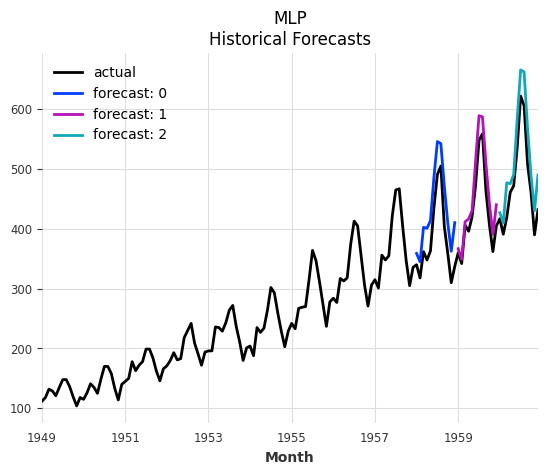

In [7]:
# get a fresh model instance and pre-train it on everything except the last 36 points
model = model.untrained_model()
model.fit(series[:-36], future_covariates=future_covariates)

# generate forecasts sequentially over the last 36 points
historical_forecasts = model.historical_forecasts(
    series=series,
    future_covariates=future_covariates,
    start=-36,
    forecast_horizon=output_chunk_length,
    stride=output_chunk_length,  # move 12 steps ahead after each forecast
    retrain=False,  # no re-training, only apply pre-trained model
    verbose=True,
    last_points_only=False,
)

ax = series.plot(label="actual")
for idx, forecast in enumerate(historical_forecasts):
    ax = forecast.plot(label=f"forecast: {idx}", ax=ax)
ax.set_title("MLP\nHistorical Forecasts");

And now we can compute any number of metrics on the historical forecasts (backtesting).

<div class="alert alert-success" role="alert">
  **Tip**: Backtesting can also generate the historical forecasts directly without us having to pre-compute them. It supports the same parameters as `historical_forecasts()`.
</div>

In [8]:
metrics = model.backtest(
    series=series,
    historical_forecasts=historical_forecasts,
    last_points_only=False,
    metric=[mae, rmse, mape],
    reduction=None,  # do not aggregate individual forecast scores
)

pd.DataFrame(
    metrics,
    columns=["MAE", "RMSE", "MAPE"],
    index=[f"forecast: {i}" for i in range(len(historical_forecasts))],
)

,MAE,RMSE,MAPE
forecast: 0,48.128937,50.333076,12.857846
forecast: 1,25.456266,29.153017,5.779883
forecast: 2,37.905315,42.028625,7.934020


## 4. Multivariate Forecasting

Multivariate (multiple target columns) forecasting is supported by all base models. Simply pass a multivariate time series as `series` to `fit()` and `predict()`.

<div class="alert alert-success" role="alert">
  **Info**: For **univariate base models**, multivariate forecasting is achieved by folding the target components into the batch dimension and repeating the covariates for each target component accordingly. This translates to **global training** and forecasting **on multiple univariate series**.
</div>

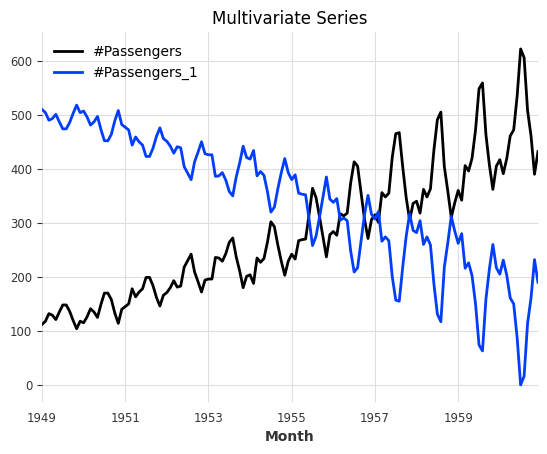

In [9]:
# generate a multivariate series
series_multivar = series.stack(series * -1 + series.max(axis=0))
series_multivar.plot(title="Multivariate Series");

Since the time index of our series hasn't changed, we can re-use the same future covariates.

Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

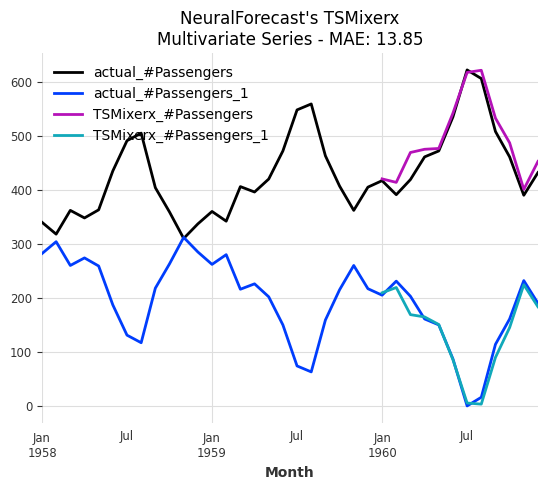

In [10]:
# let's use TSMixerx, a multivariate base model
model = NeuralForecastModel(model="TSMixerx", **darts_kwargs)

# fit and predict
model.fit(
    series=series_multivar[:-output_chunk_length],
    future_covariates=future_covariates,
)
pred = model.predict(n=output_chunk_length)

# plot
series_multivar[-3 * output_chunk_length :].plot(label="actual")
pred.plot(
    label="TSMixerx",
    title=f"NeuralForecast's TSMixerx\nMultivariate Series - MAE: {mae(series_multivar, pred):.2f}",
);

## 5. Multiple Series Forecasting

Global training and forecasting on multiple time series is supported by all base models. Simply pass a sequence of uni- or multivariate time series as ``series`` to `fit()` and `predict()`.

<div class="alert alert-success" role="alert">
  **Info**: When fitting a model on **multiple series**, we must always **pass some input series and covariates** to `predict()`. The models forecast after the end of each series. These series **do not** have to be the ones that the model was trained on!
</div>

Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

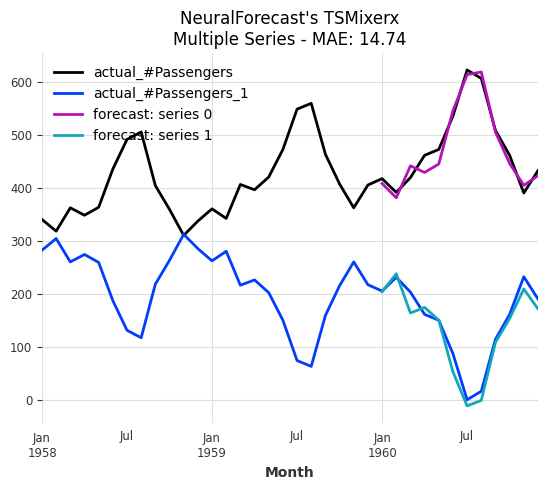

In [11]:
# split the multivariate series into two (multiple) univariate series
series_multiple = [series_multivar["#Passengers"], series_multivar["#Passengers_1"]]
series_multiple_train = [s[:-output_chunk_length] for s in series_multiple]

# since the covariates apply to both series, we can simply repeat them
future_covariates_multiple = [future_covariates] * len(series_multiple)

# get a fresh model instance
model = model.untrained_model()

# fit and predict
model.fit(
    series=series_multiple_train,
    future_covariates=future_covariates_multiple,
)
forecasts = model.predict(
    n=output_chunk_length,
    series=series_multiple_train,
    future_covariates=future_covariates_multiple,
)

# plot
ax = series_multivar[-3 * output_chunk_length :].plot(label="actual")
for idx, forecast in enumerate(forecasts):
    ax = forecast.plot(label=f"forecast: series {idx}", ax=ax)
ax.set_title(
    f"NeuralForecast's TSMixerx\nMultiple Series - MAE: "
    f"{mae(series_multiple, forecasts, series_reduction=np.mean):.2f}"
);

## 6. Probabilistic Forecasting

Probabilistic forecasting is supported by all base models thanks to our **Darts likelihood models**.

Let's use **Quantile Regression** with a **KAN** (Kolmogorov-Arnold Network) model.

<div class="alert alert-success" role="alert">
  **Info**: Darts offers many other likelihood models such as Gaussian, Poisson, Laplace and more. You can find a complete list [here](https://unit8co.github.io/darts/generated_api/darts.utils.likelihood_models.torch.html).
</div>

Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

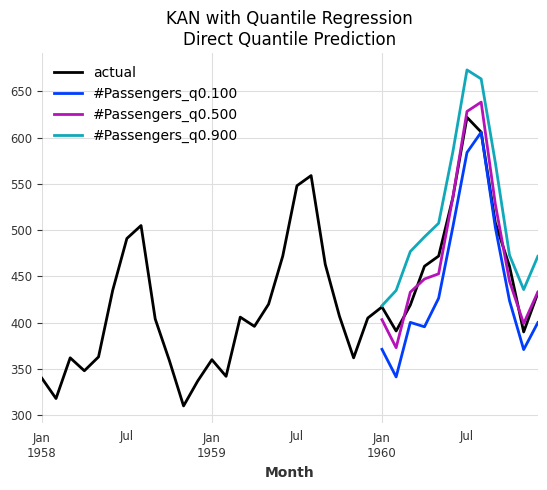

In [12]:
# KAN model that forecasts expected quantiles [0.1, 0.5, 0.9]
model = NeuralForecastModel(
    model="KAN",
    likelihood=QuantileRegression(quantiles=[0.1, 0.5, 0.9]),
    **darts_kwargs,
)

# fit and predict
model.fit(train)
pred_prob = model.predict(
    n=output_chunk_length,
    predict_likelihood_parameters=True,  # predict quantiles directly
)

# plot
series[-3 * output_chunk_length :].plot(label="actual")
pred_prob.plot(title="KAN with Quantile Regression\nDirect Quantile Prediction");

We can also generate **sampled predictions**. This is especially useful when performing auto-regression (when horizon > output_chunk_length), as it can model the increasing uncertainty with longer horizons. Essentially, it performs a **Monte Carlo Simulation** for different sample paths.

Predicting: |                                             | 0/? [00:00<?, ?it/s]

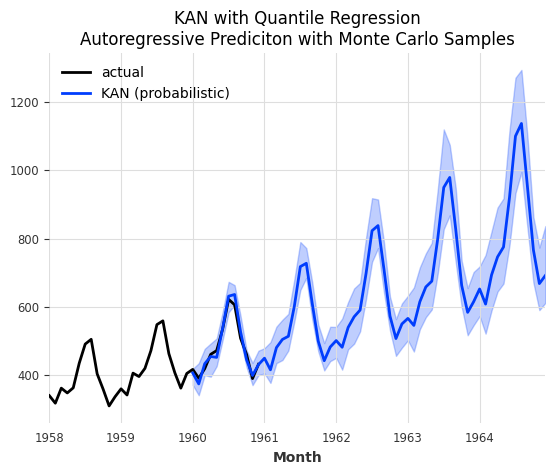

In [13]:
pred_prob = model.predict(
    n=5 * output_chunk_length,
    num_samples=200,  # sampled prediction
)

# plot
series[-3 * output_chunk_length :].plot(label="actual")
pred_prob.plot(
    label="KAN (probabilistic)",
    title="KAN with Quantile Regression\nAutoregressive Prediciton with Monte Carlo Samples",
);

## 7. Comparison: Darts TiDE vs NeuralForecast TiDE

Since Darts has its own native TiDE implementation, let's compare it side by side with the NeuralForecast version. This helps validate the integration and shows that NeuralForecast models can achieve comparable results.

We pass `model_kwargs` with similar hyperparaters as Darts' `TiDEModel` (you can find the default parameters [in the API documentation](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tide_model.html#darts.models.forecasting.tide_model.TiDEModel)).

Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

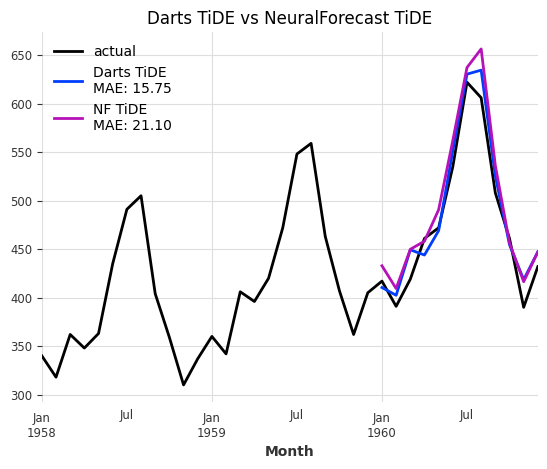

In [14]:
# Darts' TiDE model
model_darts = TiDEModel(**darts_kwargs)

# NeuralForecast's TiDE model
model_nf = NeuralForecastModel(
    model="TiDE",
    model_kwargs={
        "hidden_size": 128,
        "decoder_output_dim": 16,
        "dropout": 0.1,
        "layernorm": False,
    },
    **darts_kwargs,
)

ax = series[-3 * output_chunk_length :].plot(label="actual")

for model_i, name in [(model_darts, "Darts TiDE"), (model_nf, "NF TiDE")]:
    model_i.fit(train)
    forecast = model_i.predict(n=output_chunk_length)
    ax = forecast.plot(label=f"{name}\nMAE: {mae(val, forecast):.2f}", ax=ax)

ax.set_title("Darts TiDE vs NeuralForecast TiDE");

The two architectures are very similar but not identical. That's why we see a small difference in model performance. The difference should become negligible when performing robust model training.

You can read about more advanced techniques in our [TorchForecastingModel user guide](https://unit8co.github.io/darts/userguide/torch_forecasting_models.html#advanced-functionnalities).

## Summary

The `NeuralForecastModel` wrapper makes it easy to:

- **Access 30+ neural forecasting architectures** through a unified interface.
- **Use all Darts torch features**: Uni- & multivariate forecasting, multiple series forecasting, probabilistic forecasting, covariates (past, future, static), optimized backtesting, model saving/loading, encoders, and more.
- **Quickly experiment** with different architectures by simply changing the `model` parameter.
- **Advanced modelling techniques** are described in our [TorchForecastingModel user guide](https://unit8co.github.io/darts/userguide/torch_forecasting_models.html#advanced-functionnalities).

### Limitations

- **Recurrent models** (GRU, LSTM, RNN, DeepAR) are not supported — Darts provides native implementations.
- The core `NeuralForecast` class and automatic models (e.g. `AutoInformer`) are not supported.
- `neuralforecast>=3.0.0` must be installed separately (see the [NeuralForeacst installation guide](https://nixtlaverse.nixtla.io/neuralforecast/docs/getting-started/installation.html)).

For more information, see the [NeuralForecastModel API reference](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nf_model.html).